In [2]:
from math import sqrt
import math
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

### Smartphone Camera Position 1

In [3]:
def camera_position_1_convertion(x):

    #camera on the right hand side
    if x < 180:   #fp2 x
        Yb = 0.51    #fp2 rad
        Ya = 0.34    #fp3 rad
        Xa = 130     #fp3 x
        Xb = 180     #fp2 x 
    else:
        Yb = 0.93    #fp1 rad
        Xb = 294     #fp1 x
        Ya = 0.52    #fp2 rad
        Xa = 180     #fp2 x

    y= x* ((Yb-Ya)/(Xb-Xa)) + (((Ya*Xb)-(Yb*Xa))/(Xb-Xa))
    return 3.14-y

### Smartphone Camera Position 2

In [4]:
def camera_position_2_convertion(x):
    
    #camera on the left hand side
    
    if x > 347:      #fp2 x
        Yb = 0.36    #fp1 rad
        Xb = 404     #fp1 x     
        Ya = 0.55    #fp2 rad
        Xa = 347    #fp2 x

    else:
        Yb = 0.55    #fp2 rad
        Xb = 347    #fp2 x
        Ya = 1.01    #fp3 rad
        Xa = 210    #fp3 x

    y = x* ((Yb-Ya)/(Xb-Xa)) + (((Ya*Xb)-(Yb*Xa))/(Xb-Xa))

    return y

### Functions

In [5]:
def radian_to_degree(x):
    return (x * 180)/3.14

def degree_to_radian(x):
    return (x * 3.14)/180

def bearing(sensor, target_pos):
    '''given the sensor position and the target position calculate the angle.
    m = (y2-y1)/(x2 - x1) than teta = arctan(m)'''
    
    return math.atan2(target_pos[1] - sensor[1], 
                      target_pos[0] - sensor[0])


def measurement(A_pos, B_pos, pos):
    '''given the positions of the two sensors, and the expected position of the target, 
    this function return the angle of the target respect to the two sensor.
    A_pos is the sensor at the left position, B_pos is the sensor at the right position.
    The angles are calculated in radian and the origin of the angle is the axes x.'''
    
    angle_a = bearing(A_pos, pos)
    angle_b = bearing(B_pos, pos)
    return [angle_a, angle_b]

def fx_VOR(x, dt, u):
    '''this function predict the next position of the target, given the actual position and the u'''

    current_x = x[0] 
    current_y = x[2]
    
    next_position = estimate_next_position([current_x, current_y], u)

    x[1] = abs(next_position[0] - current_x) / 100 / dt #transform cm to m
    
    x[3] = abs(next_position[1] - current_y) / 100 / dt 
    
    
    x[0] = next_position[0]
    x[2] = next_position[1]
    return x

sa_pos = [-323, 0]
sb_pos = [350, 0]

def hx_VOR(x):
    
    '''after predict the position, hx_VOR return the angle in respect of the sensors'''
    # measurement to A
    pos = (x[0], x[2])
    #print('pos: '+str(pos))
    #print(measurement(sa_pos, sb_pos, pos))
    #print('measurement: ' + str(measurement(sa_pos, sb_pos, pos)))
    return measurement(sa_pos, sb_pos, pos)

def intercept_between_two_line(s2, s1):
    
    '''given the position of the sensor and the angles calculated previously.
    This function create to virtual stright line and calculate and return the point of intercept'''
    
    #s1 is the position on the right
    #s2 is the position on the left
    
    #z1 is the position on the right
    #z2 is the position on the left
    
    
    #print('s1: {} s2: {}'.format(s1,s2))
    m1 = np.tan(degree_to_radian(radian_to_degree(s1)))
    c1 = sb_pos[1] - sb_pos[0] * m1 
    
    m2 = np.tan(s2)
    c2 = sa_pos[1] - sa_pos[0] * m2 
        
    x = (c2 - c1)/(m1 - m2)
    y = (x * m1) + c1
    
    #print('x: {} , y: {}'.format(x,y))
    return x, y  

def callculate_u(previous_x, previous_y , current_positions, dt):
    
    '''from the real measurement (z), we calculate the u vector, which represent the distance and the direction of our target'''
    
    delta_x = previous_x- current_positions[0]
    delta_y = previous_y- current_positions[1]
    
    if delta_x== 0:
        delta_x = 0.0001
    if delta_y== 0:
        delta_y = 0.0001
        
    m = delta_y/delta_x
    distance = np.sqrt(delta_x**2 + delta_y**2)
    
    direction = np.arctan(m)
    if (current_positions[1] >=previous_y) & (current_positions[0] >=previous_x): 
    
        temp = radian_to_degree(direction)
        return [distance, temp]
    
    elif (current_positions[1] >previous_y) & (current_positions[0] < previous_x):
        temp = 180 + radian_to_degree(direction)
        return [distance, temp]   
    
    elif (current_positions[1] <previous_y) & (current_positions[0] < previous_x):
        temp = 180 + radian_to_degree(direction)
        return [distance, temp] 
    elif (current_positions[1] <previous_y) & (current_positions[0] > previous_x):
        temp = 360 + radian_to_degree(direction)
        return [distance, temp]
    
def estimate_next_position(current_position, u):

    '''given the actual position of the target, and given the vector u with distance and angle, 
    this function return the next position'''
    
    x = current_position[0]
    y = current_position[1]
    y_delta = np.sin(degree_to_radian(u[1])) * u[0]
    x_delta = np.cos(degree_to_radian(u[1])) * u[0]
    
    return [x+x_delta, y + y_delta]    

def moving_target_filter(pos, std_noise, Q, dt, kappa=0.0):
    '''step to create the initialize the unscented kalman filters'''
    
    points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=kappa)
    f = UKF(dim_x=4, dim_z=2, dt=dt, 
            hx=hx_VOR, fx=fx_VOR, points=points)
    f.x = np.array([pos[0], 1., pos[1], 1.])

    q = Q_discrete_white_noise(2, dt, Q)
    f.Q[0:2, 0:2] = q
    f.Q[2:4, 2:4] = q
    f.R *= std_noise**2
    f.P *= 200    
    return f

def plot_straight_line_target(f, std_noise, previous_position_x, previous_position_y, add_std_noise = False):
    
    xs, txs = [], []    
    
    txs.append((previous_position_x, previous_position_y))    

    for i in range(len(z_1)):
        z = [z_2[i], z_1[i]] 

        if (add_std_noise):
            z[0] += randn() * std_noise
            z[1] += randn() * std_noise
        
        temp_position_x, temp_position_y = intercept_between_two_line(z_2[i], z_1[i])
        
        current_target_position = [temp_position_x, temp_position_y]

        txs.append((temp_position_x, temp_position_y))
        
        u = callculate_u(previous_position_x, previous_position_y, current_target_position, 0.06)
        

        
        previous_position_x = temp_position_x
        previous_position_y = temp_position_y

        f.predict(u=u)

        f.update(z)
        xs.append(f.x)
                    
    xs = np.asarray(xs)
    txs = np.asarray(txs)
    #print(xs)
    plt.scatter(xs[:, 0][0], xs[:, 2][0], c ='y', s=300)
    plt.plot(xs[:, 0], xs[:, 2])
    plt.scatter(xs[:, 0][-1], xs[:, 2][-1], c ='r', s=300)
    plt.plot(txs[:, 0], txs[:, 1], ls='--', lw=2, c='k')
    plt.show()
    return xs, txs

### Experiment Setting

**sa_pos** and **sb_pos** contain the position of the two cameras  
- **sa_pos** camera on the left hand side of the experiment  
- **sb_pos** camera on the right hand side of the experiment  

In [6]:
sa_pos, sb_pos

([-323, 0], [350, 0])

**fix_position_1**, **fix_position_2** and **fix_position_3** represent the position of the three fixed positions in the room which allowed me to understand the angle between the cameras and the tracking object  

In [7]:
fix_position_1 = [150, 200]
fix_position_2 = [0, 200]
fix_position_3 = [-123, 200]

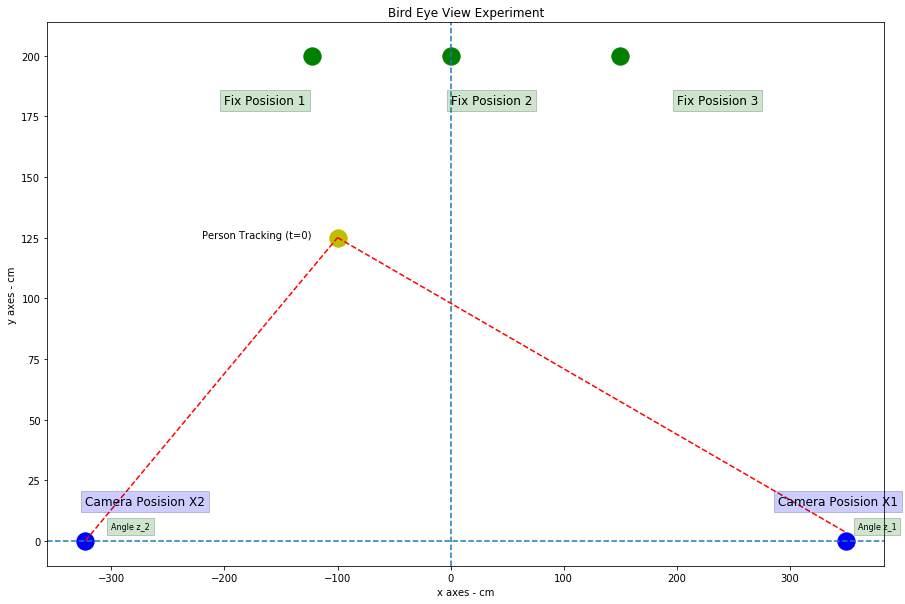

In [8]:
f = plt.figure(figsize=[15,10])
f = plt.scatter(sa_pos[0], sa_pos[1], c ='b', s=300)
f = plt.scatter(sb_pos[0], sb_pos[1], c = 'b', s=300)
f = plt.axhline(y = 0, xmin=0, xmax=1, linestyle='--')
f = plt.axvline(x = 0, ymin=0, ymax=1, linestyle='--')

f = plt.scatter(fix_position_1[0], fix_position_1[1], c ='g', s=300)
f = plt.scatter(fix_position_2[0], fix_position_2[1], c ='g', s=300)
f = plt.scatter(fix_position_3[0], fix_position_3[1], c ='g', s=300)

x2 = np.linspace(-323,-100,100)
y2 = 0.56*x2+181
f = plt.plot(x2, y2, '--r')

x1 = np.linspace(-100,350,100)
y1 = -0.27*x1+98
f = plt.plot(x1, y1, '--r')

f = plt.text(-323, 15, 'Camera Posision X2', fontsize=12, bbox=dict(facecolor='blue', alpha=0.2))
f = plt.text(290, 15, 'Camera Posision X1', fontsize=12, bbox=dict(facecolor='blue', alpha=0.2))

f = plt.text(-200, 180, 'Fix Posision 1', fontsize=12, bbox=dict(facecolor='green', alpha=0.2))
f = plt.text(0, 180, 'Fix Posision 2', fontsize=12, bbox=dict(facecolor='green', alpha=0.2))
f = plt.text(200, 180, 'Fix Posision 3', fontsize=12, bbox=dict(facecolor='green', alpha=0.2))

f = plt.ylabel('y axes - cm')
f = plt.xlabel('x axes - cm')

f = plt.text(-300, 5, 'Angle z_2', fontsize=8, bbox=dict(facecolor='green', alpha=0.2))
f = plt.text(360, 5, 'Angle z_1', fontsize=8, bbox=dict(facecolor='green', alpha=0.2))


f = plt.scatter(-100,125, c ='y', s=300 )
f = plt.text(-220, 125, 'Person Tracking (t=0)')

f = plt.title('Bird Eye View Experiment')

### The data

In [21]:
video_number = 1
data_x1 = pd.read_csv('../Data/Data from camera in X1 and X2/Video{} S10 position X1.csv'.format(video_number))
data_x2 = pd.read_csv('../Data/Data from camera in X1 and X2/Video{} S10 position X2.csv'.format(video_number))
data_x1 = data_x1.drop(['Unnamed: 0'], axis=1)
data_x2 = data_x2.drop(['Unnamed: 0'], axis=1)

In [22]:
print('Camera on the right - position X1')
display(data_x1.head())
print('\n\nCamera on the left - position X2')
display(data_x2.head())

Camera on the right - position X1


,object_id,frame_list,x-coordinate,y-coordinate
0,0,1,163,261
1,0,2,161,262
2,0,3,160,262
3,0,4,159,262
4,0,5,158,262




Camera on the left - position X2


,object_id,frame_list,x-coordinate,y-coordinate
0,0,1,332,243
1,0,2,331,242
2,0,3,330,242
3,0,4,327,241
4,0,5,323,241


#### plot data_x1 and data_x2 

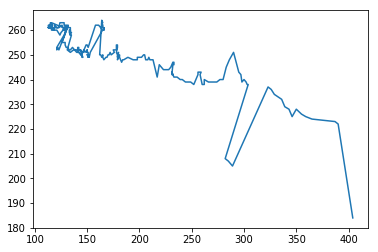

In [11]:
plt.plot(data_x1['x-coordinate'], data_x1['y-coordinate']);

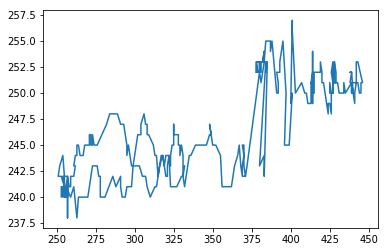

In [12]:
plt.plot(data_x2['x-coordinate'], data_x2['y-coordinate']);

##### calculate the angles from x and y positions

In [13]:
angles_position_1 = [camera_position_1_convertion(x) for x in data_x1['x-coordinate']]
angles_position_2 = [camera_position_2_convertion(x) for x in data_x2['x-coordinate']]
data_x1['angle'] = angles_position_1
data_x2['angle'] = angles_position_2

In [14]:
print('Camera on the right - position X1')
display(data_x1.head())
print('\n\nCamera on the left - position X2')
display(data_x2.head())

Camera on the right - position X1


,object_id,frame_list,x-coordinate,y-coordinate,angle
0,0,1,163,261,2.6878
1,0,2,161,262,2.6946
2,0,3,160,262,2.6980
3,0,4,159,262,2.7014
4,0,5,158,262,2.7048




Camera on the left - position X2


,object_id,frame_list,x-coordinate,y-coordinate,angle
0,0,1,332,243,0.600365
1,0,2,331,242,0.603723
2,0,3,330,242,0.607080
3,0,4,327,241,0.617153
4,0,5,323,241,0.630584


### Main - apply Kalman Filter for Data Fusion (only on S10 data)

video number: 1


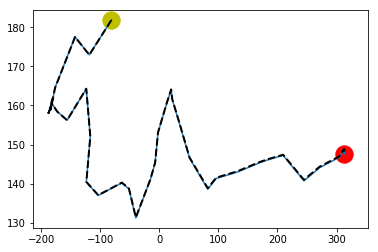

,x,vel_x,y,vel_y,velocity
0,-81.781197,8.202114e-08,181.784068,4.669164e-09,3.485838e-07
1,-118.863524,7.420072e-01,172.970307,1.755438e-01,7.623074e-01
2,-142.986728,4.825677e-01,177.587811,9.274007e-02,4.912231e-01
3,-176.890959,6.784646e-01,164.573780,2.599119e-01,7.263228e-01
4,-184.249015,1.473514e-01,159.059662,1.100008e-01,1.838983e-01


video number: 2


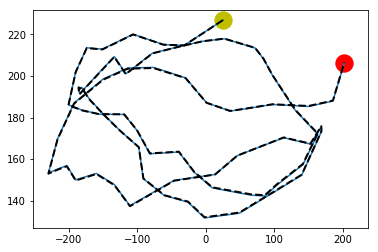

,x,vel_x,y,vel_y,velocity
0,24.871752,4.384829e-08,226.806490,2.043940e-09,1.969250e-07
1,-31.076507,1.119413e+00,214.748649,2.401180e-01,1.144657e+00
2,-61.405336,6.067528e-01,215.119813,8.018658e-03,6.066220e-01
3,-105.744873,8.869841e-01,220.101590,1.001902e-01,8.923705e-01
4,-150.618205,8.978039e-01,212.930655,1.428905e-01,9.088538e-01


video number: 3


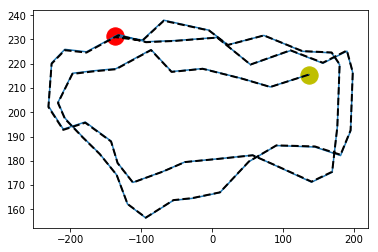

,x,vel_x,y,vel_y,velocity
0,136.329549,9.087011e-08,215.495693,5.817582e-08,2.251962e-07
1,82.302397,1.080876e+00,210.462754,9.962730e-02,1.085221e+00
2,42.364175,7.989449e-01,213.914408,6.977472e-02,8.017420e-01
3,-13.233132,1.112241e+00,218.024166,8.298883e-02,1.114980e+00
4,-57.148650,8.786318e-01,216.782213,2.412443e-02,8.786615e-01


video number: 4


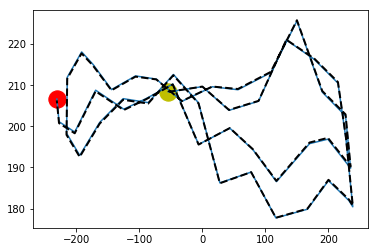

,x,vel_x,y,vel_y,velocity
0,-53.722596,3.734434e-08,208.368803,6.012132e-08,1.661993e-07
1,0.145854,1.077467e+00,209.652534,2.581317e-02,1.077675e+00
2,42.434343,8.453060e-01,203.888308,1.162302e-01,8.535907e-01
3,89.250076,9.360779e-01,206.113783,4.407137e-02,9.373720e-01
4,133.342082,8.817342e-01,220.994188,2.973911e-01,9.307054e-01


video number: 5


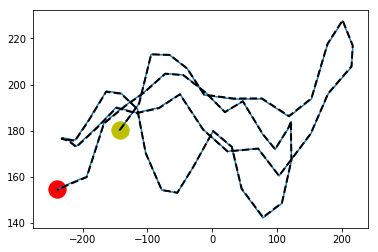

,x,vel_x,y,vel_y,velocity
0,-142.934696,4.866527e-08,180.176931,8.635312e-08,1.246473e-07
1,-112.879145,6.012049e-01,191.787192,2.323429e-01,6.444018e-01
2,-94.308733,3.713991e-01,213.094825,4.261548e-01,5.652877e-01
3,-65.636383,5.732861e-01,212.778457,6.829736e-03,5.734819e-01
4,-38.574135,5.409229e-01,206.828089,1.197332e-01,5.541740e-01


video number: 6


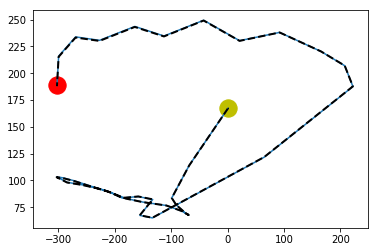

,x,vel_x,y,vel_y,velocity
0,0.894425,4.563380e-08,167.344213,1.702741e-08,3.432355e-07
1,-68.167363,1.382603e+00,113.911620,1.067151e+00,1.746376e+00
2,-99.010969,6.175052e-01,83.628075,6.048591e-01,8.645047e-01
3,-91.205388,1.559567e-01,77.182141,1.287340e-01,2.024620e-01
4,-74.788550,3.281943e-01,69.509052,1.536142e-01,3.624300e-01


video number: 7


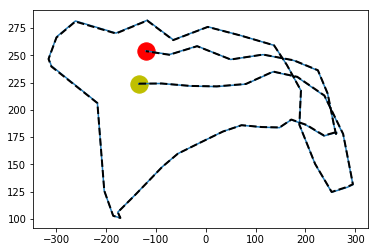

,x,vel_x,y,vel_y,velocity
0,-134.535270,6.124436e-08,223.944150,1.902902e-08,1.914942e-07
1,-88.579119,9.191940e-01,224.092163,3.032754e-03,9.191278e-01
2,-29.845428,1.174192e+00,221.722967,4.884108e-02,1.175629e+00
3,22.115344,1.038546e+00,221.270853,1.066210e-02,1.039255e+00
4,80.555136,1.168435e+00,223.538737,4.453380e-02,1.169676e+00


video number: 8


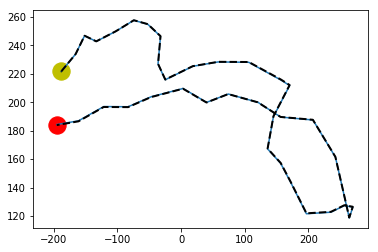

,x,vel_x,y,vel_y,velocity
0,-188.095013,5.991236e-08,221.676958,7.463609e-08,6.702806e-07
1,-165.526384,4.514034e-01,233.882979,2.441600e-01,5.131588e-01
2,-151.527140,2.799838e-01,246.727076,2.568834e-01,3.799735e-01
3,-133.213733,3.661797e-01,242.725937,8.035196e-02,3.749080e-01
4,-102.613686,6.119374e-01,249.805339,1.413823e-01,6.281658e-01


video number: 9


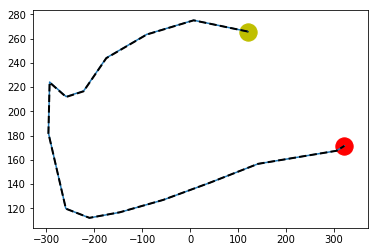

,x,vel_x,y,vel_y,velocity
0,119.961349,4.316765e-08,265.858286,6.489840e-08,2.024519e-07
1,7.069401,2.258192e+00,275.168410,1.880411e-01,2.265504e+00
2,-90.614452,1.954301e+00,263.547295,2.308455e-01,1.967454e+00
3,-175.069682,1.689815e+00,244.096558,3.878001e-01,1.733322e+00
4,-222.474411,9.487455e-01,216.771598,5.456046e-01,1.094324e+00


video number: 10


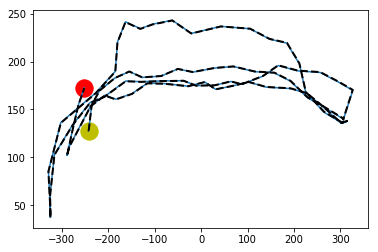

,x,vel_x,y,vel_y,velocity
0,-241.595653,7.762245e-08,127.574696,2.539376e-08,0.000004
1,-235.083623,1.301956e-01,154.642112,5.414507e-01,0.556795
2,-217.986734,3.419605e-01,169.715940,3.014802e-01,0.455861
3,-185.405164,6.516397e-01,182.727659,2.602073e-01,0.701673
4,-154.149318,6.251184e-01,189.603008,1.374830e-01,0.640062


In [27]:
video_list = range(1,11)


for video_number in video_list:
    print('video number: ' +str(video_number))
    data_x1 = pd.read_csv('../Data/Data from camera in X1 and X2/Video{} S10 position X1.csv'.format(video_number))
    data_x2 = pd.read_csv('../Data/Data from camera in X1 and X2/Video{} S10 position X2.csv'.format(video_number))
    data_x1 = data_x1.drop(['Unnamed: 0'], axis=1)
    data_x2 = data_x2.drop(['Unnamed: 0'], axis=1)
    angles_position_1 = [camera_position_1_convertion(x) for x in data_x1['x-coordinate']]
    angles_position_2 = [camera_position_2_convertion(x) for x in data_x2['x-coordinate']]
    data_x1['angle'] = angles_position_1
    data_x2['angle'] = angles_position_2

    z_1 = []
    for i in range(16,len(data_x1),15):
        z_1.append(data_x1['angle'][i-15:i].mean())
    z_2 = []
    for i in range(16,len(data_x2),15):
        z_2.append(data_x2['angle'][i-15:i].mean())
    distance = abs(len(z_1) - len(z_2))
    if distance>0:
        for i in range(distance):
            if len(z_1) > len(z_2):
                del z_1[-1]
            else:
                del z_2[-1]
    
    np.random.seed(123)
    target_temp = intercept_between_two_line(z_2[0], z_1[0])
    target_pos = [0,0]
    target_pos[0] = round(target_temp[0],5)
    target_pos[1] = round(target_temp[1],5)
    std_noise = math.radians(0.5)
    dt = 0.5
    Q=1.0
    f = moving_target_filter(target_pos, std_noise, Q , dt)
    xs, txs = plot_straight_line_target(f, std_noise, target_pos[0], target_pos[1], add_std_noise=False)


    df_kalman = pd.DataFrame(xs)
    df_kalman.columns = ['x', 'vel_x', 'y', 'vel_y']

    initial_position_target = target_pos
    dt = 0.5
    velocity = []
    for row in range(len(df_kalman)):
        x = df_kalman['x'][row]
        y = df_kalman['y'][row]
        if row ==0:
            previous_x = initial_position_target[0]
            previous_y = initial_position_target[1]
        else:
            previous_x = df_kalman['x'][row -1]
            previous_y = df_kalman['y'][row -1]
        distance = sqrt((x - previous_x)**2 + (y - previous_y)**2)
        velocity.append(distance/100/dt)

    df_kalman['velocity'] = velocity
    display(df_kalman.head())
    
    #store the data fused
    start = False
    if (start):    
        df_kalman.to_csv('../Data/Data fusion/Video{} - fusion.csv'.format(video_number), index = False)

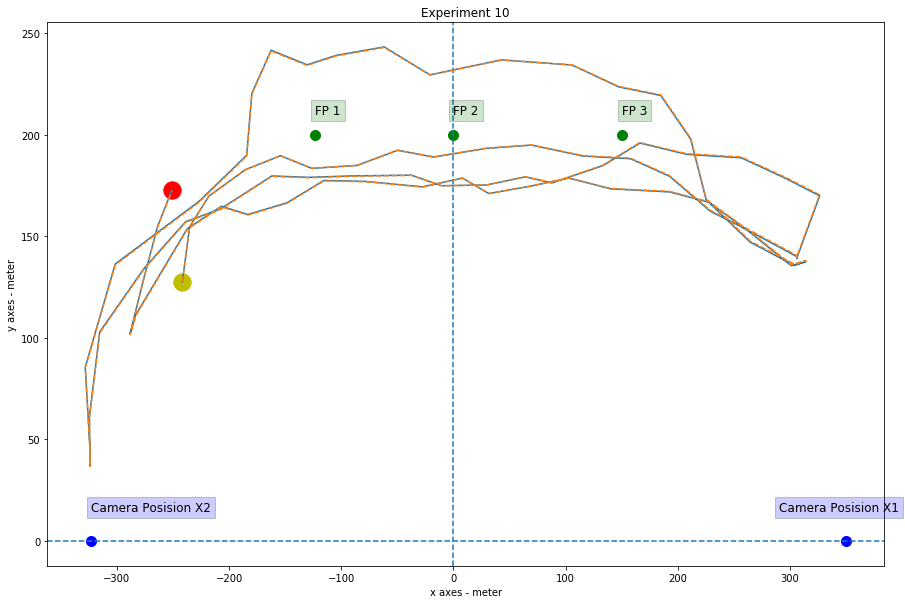

In [24]:
f = plt.figure(figsize=[15,10])
f = plt.scatter(sa_pos[0], sa_pos[1], c ='b', s=100)
f = plt.scatter(sb_pos[0], sb_pos[1], c = 'b', s=100)
f = plt.axhline(y = 0, xmin=0, xmax=1, linestyle='--')
f = plt.axvline(x = 0, ymin=0, ymax=1, linestyle='--')

f = plt.scatter(fix_position_1[0], fix_position_1[1], c ='g', s=100)
f = plt.scatter(fix_position_2[0], fix_position_2[1], c ='g', s=100)
f = plt.scatter(fix_position_3[0], fix_position_3[1], c ='g', s=100)


f = plt.text(-323, 15, 'Camera Posision X2', fontsize=12, bbox=dict(facecolor='blue', alpha=0.2))
f = plt.text(290, 15, 'Camera Posision X1', fontsize=12, bbox=dict(facecolor='blue', alpha=0.2))

f = plt.text(-123, 210, 'FP 1', fontsize=12, bbox=dict(facecolor='green', alpha=0.2))
f = plt.text(0, 210, 'FP 2', fontsize=12, bbox=dict(facecolor='green', alpha=0.2))
f = plt.text(150, 210, 'FP 3', fontsize=12, bbox=dict(facecolor='green', alpha=0.2))

f = plt.ylabel('y axes - meter')
f = plt.xlabel('x axes - meter')

f = plt.scatter(xs[:, 0][0], xs[:, 2][0], c ='y', s=300)
f = plt.plot(xs[:, 0], xs[:, 2])
f = plt.plot(txs[:, 0], txs[:, 1], '--')
f = plt.scatter(xs[:, 0][-1], xs[:, 2][-1], c ='r', s=300)


f = plt.title('Experiment '+str(video_number))

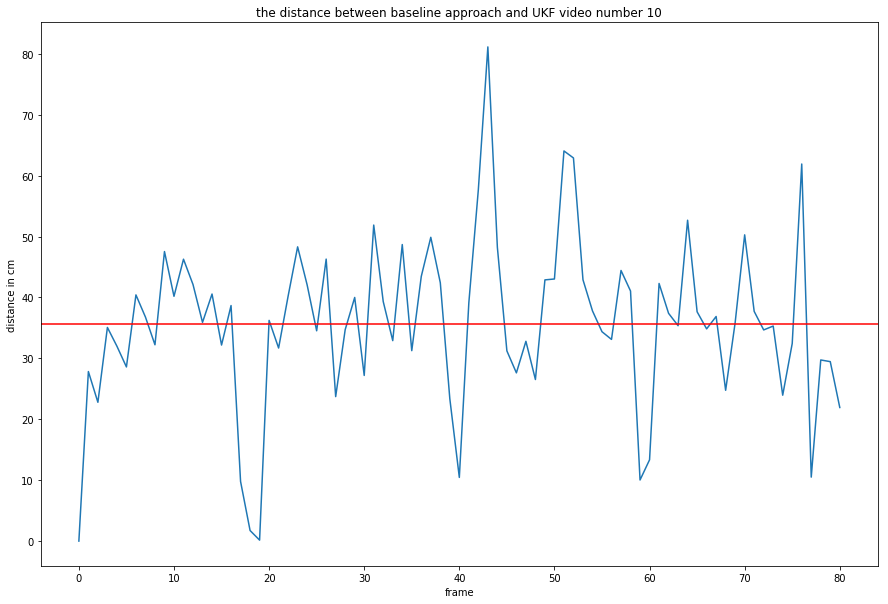

In [25]:
distance = []
for i in range(len(xs)):
    distance.append(sqrt(abs(txs[:,0][i] - xs[:,0][i])**2 + abs(txs[:,1][i] - xs[:,2][i])**2))
  
f = plt.figure(figsize=[15,10])
f = plt.plot(range(len(xs)), distance)
f = plt.xlabel('frame')
f = plt.ylabel('distance in cm')
f = plt.title('the distance between baseline approach and UKF video number '+str(video_number))
f = plt.axhline(y = np.array(distance).mean(), xmin=0 , xmax=1 , color='red')